In [ ]:
import h5py
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pde
from pprint import pprint
from IPython.display import Video

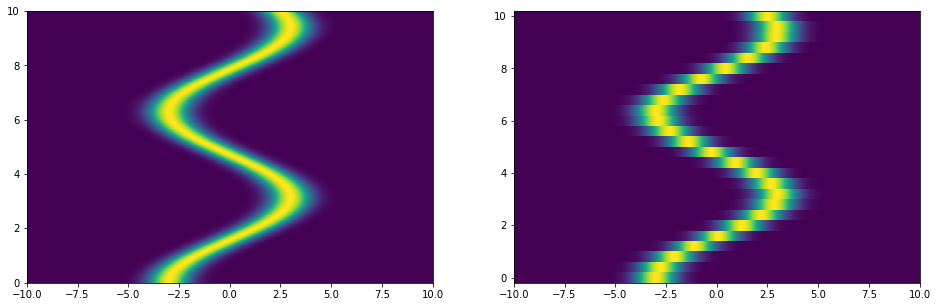

In [ ]:
# Effect of different timesteps:

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.pcolormesh(x,t, np.abs(u)**2)
ax2.pcolormesh(x,t[::40], np.abs(u[::40,:])**2)

In [ ]:
n_iter=10

results = {'jump%i' % i : [] for i in range(1,n_iter+1)}

for jump in range(1,n_iter+1):

    print('\n ITERATION:',jump,'\n')

    ## LOAD DATA ## 

    data = h5py.File('./Data/Simulations/Quantum_Osc_w_1.h5')

    t = np.array(data['times'][::jump])
    dt = t[1]-t[0]

    x = np.array(data['x'])
    dx = x[1]-x[0]

    u = np.array(data['data'][::jump,:])
    u_dot = ps.FiniteDifference(axis=0)._differentiate(u, t=dt)


    data.close()


    ## GET REAL AND IMG PART TO USE WITH SINDY ## 

    u_real = np.real(u)
    u_img = np.imag(u)


    u_dot_real = np.real(u_dot)
    u_dot_img = np.imag(u_dot)

    u_shaped = np.zeros(shape=(len(x), len(t), 3))
    u_shaped[:,:, 0]=u_real.T
    u_shaped[:,:, 1]=u_img.T
    u_shaped[:,:, 2]=np.tile(x,(len(t),1)).T # add x values to pass to u and u_dot (in these way one can introduce spatial potential terms)

    u_dot_shaped = np.zeros(shape=(len(x), len(t), 2))
    u_dot_shaped[:,:, 0]=u_dot_real.T
    u_dot_shaped[:,:, 1]=u_dot_img.T

    u_shaped.shape

    ## DEFINE CANDIDATES LIBRARY ## 

    # 2nd order poly library
    poly_library = ps.PolynomialLibrary(include_bias=False, degree=2) 

    # PDE library
    library_functions = [lambda x: x]
    library_function_names = [lambda x: x]
    pde_library = ps.PDELibrary(library_functions=library_functions, 
                            function_names=library_function_names, 
                            derivative_order=2, spatial_grid=x, 
                            include_bias=True, is_uniform=True, include_interaction=False)

    # Tensor polynomial library with the PDE library
    tensor_array = [[1, 1]]
    inputs_temp = np.tile([0, 1, 2], 2)
    inputs_per_library = np.reshape(inputs_temp, (2, 3))
    inputs_per_library[1,2] = 0 # only compute PDs for psi_real and psi_img
    inputs_per_library[0] = [2, 2, 2] # only compute polynomial for x input feature


    generalized_library = ps.GeneralizedLibrary(
        [poly_library, pde_library],
        tensor_array=tensor_array,
        inputs_per_library=inputs_per_library,
    )

    ## DEFINE OPTIMIZER AND FIT MODEL ## 

    optimizer = ps.STLSQ(threshold=0.1, verbose=True)
    model = ps.SINDy(feature_library=generalized_library, optimizer=optimizer, feature_names=['psi_r', 'psi_i', 'x'])
    model.fit(u_shaped, x_dot=u_dot_shaped, t=dt)
    model.print()

    print(generalized_library.get_feature_names(), "\n")

    cf = model.coefficients()
    results['jump%i' % jump] = [cf[(cf != 0)]]

pprint(results, sort_dicts=False)


 ITERATION: 1 

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.3739e+00 ... 4.9839e-02 ...          4 ... 1.4238e+00
         1 ... 4.3597e-01 ... 4.9918e-02 ...          4 ... 4.8589e-01
(psi_r)' = -0.500 psi_i_11 + 0.500 x^2 psi_i
(psi_i)' = 0.500 psi_r_11 + -0.500 x^2 psi_r
['x2', 'x2^2', '1', 'x0', 'x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'x2 1', 'x2 x0', 'x2 x1', 'x2 x0_1', 'x2 x1_1', 'x2 x0_11', 'x2 x1_11', 'x2^2 1', 'x2^2 x0', 'x2^2 x1', 'x2^2 x0_1', 'x2^2 x1_1', 'x2^2 x0_11', 'x2^2 x1_11'] 


 ITERATION: 2 

 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.0990e+01 ... 4.9362e-02 ...          4 ... 1.1040e+01
         1 ... 3.6248e+00 ... 4.9676e-02 ...          4 ... 3.6745e+00
(psi_r)' = -0.498 psi_i_11 + 0.498 x^2 psi_i
(psi_i)' = 0.498 psi_r_11 + -0.498 x^2 psi_r
['x2', 'x2^2', '1', 'x0', 'x1', 'x0_1', 'x1_1', 'x0_11', 'x1_11', 'x2 1', 'x2 x0', '

In [ ]:
M_res = np.zeros((n_iter,6))

for j,key in enumerate(results):
    
    if (len(results[key])==0): pass
    elif(len(results[key][0])==4):
        r = results[key][0]
        M_res[j]=np.array([0,r[0],r[1],0,r[2],r[3]])
    else: 
        r = results[key][0]
        M_res[j] = np.array(r)

print(M_res)

[[ 0.         -0.49959155  0.49958859  0.          0.49958903 -0.49959668]
 [ 0.         -0.49837073  0.49836289  0.          0.49835218 -0.49842143]
 [ 0.         -0.49634094  0.49634308  0.          0.49628069 -0.49653269]
 [ 0.         -0.49351384  0.49354788  0.          0.49337569 -0.49398119]
 [ 0.13114984 -0.47876024  0.47891877 -0.12881305  0.47870678 -0.47991108]
 [ 0.18721921 -0.46956324  0.46996492 -0.18296699  0.46951134 -0.47163741]
 [ 0.25229672 -0.45882315  0.45958805 -0.24565801  0.45876926 -0.462121  ]
 [ 0.32708162 -0.4466679   0.44751931 -0.31551469  0.44671034 -0.45146988]
 [ 0.40958876 -0.43300275  0.43433834 -0.39325729  0.43311567 -0.43976805]
 [ 0.50010755 -0.41801747  0.4198013  -0.4779397   0.41821795 -0.42703366]]


Text(0.5, 1.0, '$x^2\\psi_r$')

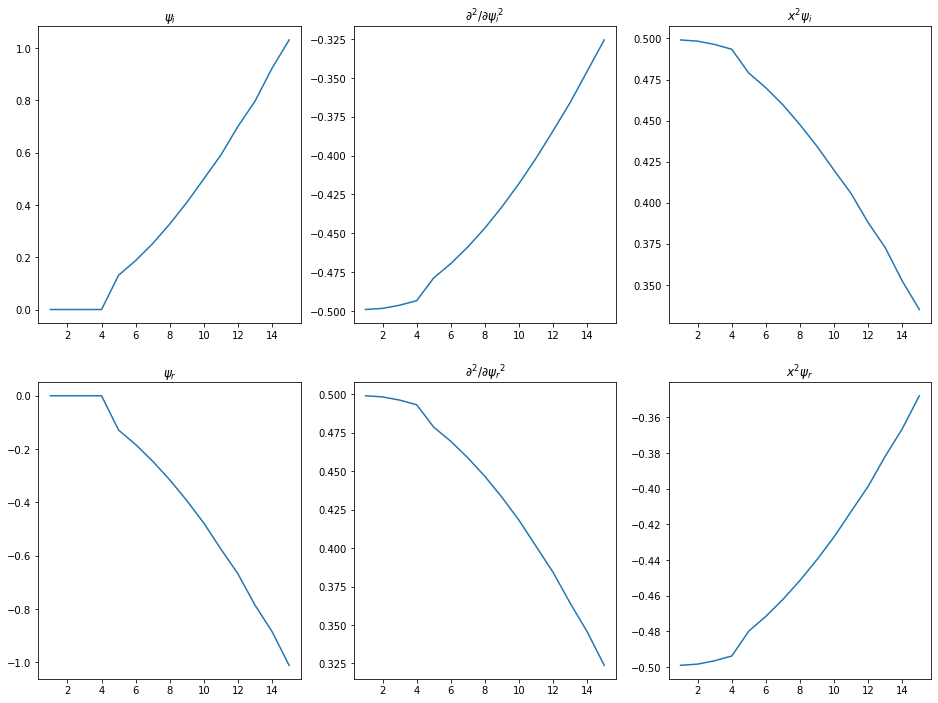

In [ ]:
fig, ((ax1,ax2, ax3), (ax4,ax5,ax6)) = plt.subplots(2,3, figsize=(16,12))
ax1.plot(range(1,n_iter+1),M_res[:,0])
ax1.set_title('$\psi_i$')
ax2.plot(range(1,n_iter+1),M_res[:,1])
ax2.set_title('${\partial^2}/{\partial{\psi_i}^2}$')
ax3.plot(range(1,n_iter+1),M_res[:,2])
ax3.set_title('$x^2\psi_i$')
ax4.plot(range(1,n_iter+1),M_res[:,3])
ax4.set_title('$\psi_r$')
ax5.plot(range(1,n_iter+1),M_res[:,4])
ax5.set_title('${\partial^2}/{\partial{\psi_r}^2}$')
ax6.plot(range(1,n_iter+1),M_res[:,5])
ax6.set_title('$x^2\psi_r$')


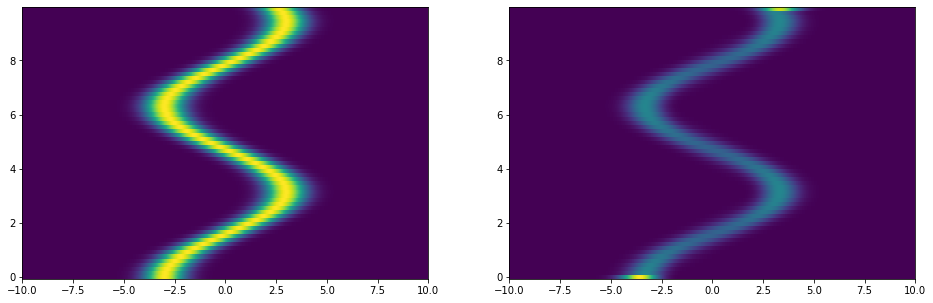

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.pcolormesh(x,t, np.abs(u)**2)
ax2.pcolormesh(x,t, np.abs(u_dot)**2)

In [ ]:
print(t.shape, x.shape, u.shape)

(67,) (1000,) (67, 1000)


## Fit reconstruction and simulation

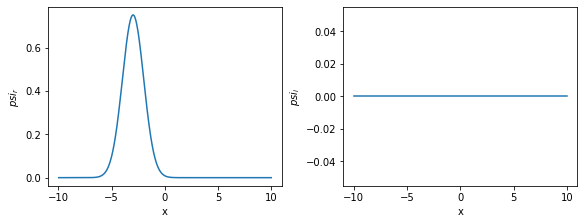

In [ ]:
## FITTED MODEL SIMULATION ## 

# TO DO: GENERALIZE EQUATION WRITING FROM MODEL RESULT

uxx_re = model.coefficients()[0,8]
uxx_im = model.coefficients()[1,7]
x2psi_re = model.coefficients()[0,18]
x2psi_im = model.coefficients()[1,17]
const_re = model.coefficients()[0,4]
const_im = model.coefficients()[1,3]


eq = pde.PDE({'psi_r':'{}*laplace(psi_i)+({}*x*x + {})*psi_i'.format(uxx_re, x2psi_re, const_re ), 
              'psi_i':'{}*laplace(psi_r)+({}*x*x + {})*psi_r'.format(uxx_im, x2psi_im, const_im)})

## DEFINE SPATIAL GRID ##

Nx = len(x) # number of spatial points
x_left = x[0]
x_right = x[-1]

grid = pde.CartesianGrid([(x_left,x_right)], Nx, periodic=False)
grid.coordinate_arrays = (x,) # this is needed otherwise endpoints are excluded

## DEFINE INITIAL STATE FOR SIMULATION (use last u entry) ##

initial_state_r = pde.ScalarField(grid, u_real[0], label= '$psi_r$')
initial_state_i = pde.ScalarField(grid, u_img[0], label = '$psi_i$')

initial_state = pde.FieldCollection([initial_state_r, initial_state_i])

initial_state.plot()


In [ ]:
## PERFORM SIMULATION ##

# define storage 
storage = pde.MemoryStorage() # for movie

# simulation time and step (1e-6 and 1e-5 seems to work, more testing needed to se if less can be used)
t_range = 5
dt_sim = 1e-5

# points to use in animation 
N_t_anim = 500 # this is enough do not change it 
dt_anim = t_range/N_t_anim


solver = pde.ExplicitSolver(eq, scheme="runge-kutta", adaptive=False)
controller = pde.Controller(solver, t_range=t_range, tracker=['progress', storage.tracker(interval=dt_anim)])
_ = controller.run(initial_state, dt=dt_sim)

100%|██████████| 5.0/5.0 [01:18<00:00, 15.77s/it]


In [ ]:
## COMBINE REAL AND IMAGINARY PART ## 

data_sim = np.array([storage.data[i][0]+1j*storage.data[i][1] for i in range(len(storage))])
storage_sim = pde.MemoryStorage(times=t[0] + np.array(storage.times), data=data_sim, field_obj=pde.ScalarField(grid, label='$psi_sim$', dtype=np.complex128))


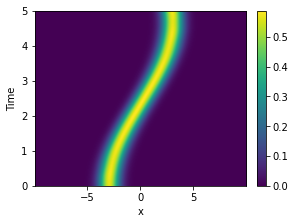

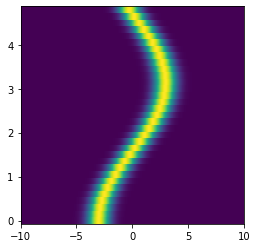

In [ ]:
## PLOT SIMULATION ##

pde.plot_kymographs(storage_sim, scalar='norm_squared')

fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.pcolormesh(x, t[:int(t.shape[0]/2)], np.abs(u[:int(u.shape[0]/2),:])**2)
plt.xlim(-10,10)
plt.show()

100%|██████████| 501/501 [00:38<00:00, 13.00it/s]


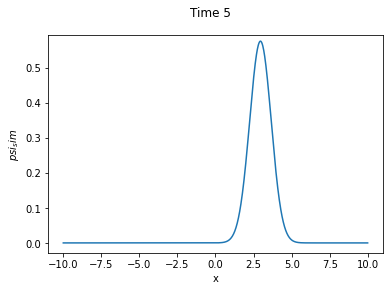

In [ ]:
## CREATE MOVIE ## 

pde.movie(storage_sim, 'broken_timestep_15.mp4', plot_args={'scalar':'norm_squared'}) # TODO: ADD LABELS 

In [ ]:
## VISUALIZE MOVIE ## Does not work in Deepnote...

Video('broken_timestep_15.mp4')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=964d390d-0269-41ab-86ee-4ee3752d1778' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>